In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
from pathlib import Path
base_path = Path("../eval_results/")

In [2]:
sns.__version__

'0.11.2'

In [148]:
results = pd.DataFrame()
runs = [x for x in os.listdir(base_path) if not os.path.isfile(x)]
for run in runs:
    run_int = int(run.split("_")[-1])
    if run_int > 1:
        continue
    approaches = [x for x in os.listdir(base_path / run) if not os.path.isfile(x)]
    for approach in approaches:
        datasets = os.listdir(base_path / run / approach)
        for dataset in datasets:
            df = pd.read_csv(base_path / run/approach / dataset)
            df["Method"] = approach
            df["dataset"] = dataset
            df["run"] = int(run.split("_")[-1])


            max_iter = df["iteration"].max()
            while max_iter < 70:
                max_iter += 1
                new_df = pd.DataFrame(df[-1:].values, columns=df.columns)
                new_df["iteration"] = max_iter
                df = df.append(new_df)
            #if "ml2dac" in approach:                
            results = pd.concat([results, df])
results["Best ARI"] = pd.to_numeric(results["Best ARI"])
results["Best NMI"] = pd.to_numeric(results["Best NMI"])
results["ARI"] = pd.to_numeric(results["ARI"])
results["NMI"] = pd.to_numeric(results["NMI"])
results["Best CVI score"] = pd.to_numeric(results["Best CVI score"])
results["wallclock time"] = pd.to_numeric(results["wallclock time"])

In [160]:
fmnist_data_not_ready = [f"Fashion-MNIST_n{i}0000_f784_c10.csv" for i in range(3, 7)] #?
all_fmnist_data = [f"Fashion-MNIST_n{i}0000_f784_c10.csv" for i in range(1,8)]
bad_data = ["haberman.csv", "german.csv", "balance-scale.csv", "arrhythmia.csv", 
            "heart-statlog.csv", 
            "sonar.csv", 
            "tae.csv", 
            "vehicle.csv"]
new_added_data = [f"mnist_784_n{i}0000_f784_c10.csv" for i in range(1, 8)]
new_added_data.append("miceprotein_n1080_f77_c8.csv")
new_added_data.append("har_n10299_f561_c6.csv")

In [150]:
new_added_data

['mnist_784_n10000_f784_c10.csv',
 'mnist_784_n20000_f784_c10.csv',
 'mnist_784_n30000_f784_c10.csv',
 'mnist_784_n40000_f784_c10.csv',
 'mnist_784_n50000_f784_c10.csv',
 'mnist_784_n60000_f784_c10.csv',
 'mnist_784_n70000_f784_c10.csv',
 'miceprotein_n1080_f77_c8.csv',
 'har_n10299_f561_c6.csv']

In [151]:
results[["Best ARI", "Best NMI", "wallclock time"]].describe()

,Best ARI,Best NMI,wallclock time
count,42322.000000,42322.000000,42322.000000
mean,-0.198300,-0.298908,235.910658
std,0.240909,0.250067,984.362933
min,-0.954391,-0.933558,0.001805
25%,-0.314525,-0.497307,1.366948
50%,-0.095706,-0.229401,4.432101
75%,-0.017799,-0.100043,18.300389
max,0.093876,0.003931,8515.596385


In [152]:
results[(results["run"].isin([0,1])) 
                          & (results["Method"].isin(["ml2dac", "effens"]))
       #                  & (~results["dataset"].isin(bad_data))
       ]

,runtime,iteration,config,dataset,mf time,similar dataset,cvi,algorithms,Method,CVI score,...,k_pred,config_ranking,run,cf,gen_time,gen_ari,gen_nmi,gen_cvi,m,rs
0,0.350739,1,"{'cc_function': 'ACV', 'k': 2, 'm': 7}",arrhythmia.csv,NaN,NaN,DBCV,NaN,effens,0.69278,...,15,14.0,0,ACV,0.767557,-0.038128,-0.100416,0.373148,7.0,0.0
1,0.197869,2,"{'cc_function': 'ACV', 'k': 69, 'm': 7}",arrhythmia.csv,NaN,NaN,DBCV,NaN,effens,1.0,...,15,42.5,0,ACV,0.767557,-0.038128,-0.100416,0.373148,7.0,0.0
2,0.323165,3,"{'cc_function': 'ACV', 'k': 5, 'm': 7}",arrhythmia.csv,NaN,NaN,DBCV,NaN,effens,0.614429,...,15,11.0,0,ACV,0.767557,-0.038128,-0.100416,0.373148,7.0,0.0
3,0.334608,4,"{'cc_function': 'ACV', 'k': 3, 'm': 7}",arrhythmia.csv,NaN,NaN,DBCV,NaN,effens,0.653078,...,15,13.0,0,ACV,0.767557,-0.038128,-0.100416,0.373148,7.0,0.0
4,0.317362,5,"{'cc_function': 'ACV', 'k': 8, 'm': 7}",arrhythmia.csv,NaN,NaN,DBCV,NaN,effens,0.567382,...,15,8.0,0,ACV,0.767557,-0.038128,-0.100416,0.373148,7.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.006235,96,"{'algorithm': 'dbscan', 'eps': 0.1499381669668...",zoo.csv,0.022131,type=varied-k=10-n=1000-d=50-noise=0,DBCV,MBKMeans+GMM+KMeans+birch+dbscan+ward,ml2dac,-0.324202,...,7,2.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
96,0.010953,97,"{'algorithm': 'birch', 'n_clusters': 19}",zoo.csv,0.022131,type=varied-k=10-n=1000-d=50-noise=0,DBCV,MBKMeans+GMM+KMeans+birch+dbscan+ward,ml2dac,1.0,...,7,66.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
97,0.00336,98,"{'algorithm': 'dbscan', 'eps': 0.0261901837259...",zoo.csv,0.022131,type=varied-k=10-n=1000-d=50-noise=0,DBCV,MBKMeans+GMM+KMeans+birch+dbscan+ward,ml2dac,-0.158416,...,7,21.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
98,0.005948,99,"{'algorithm': 'dbscan', 'eps': 0.1282738057353...",zoo.csv,0.022131,type=varied-k=10-n=1000-d=50-noise=0,DBCV,MBKMeans+GMM+KMeans+birch+dbscan+ward,ml2dac,-0.324202,...,7,2.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<AxesSubplot:xlabel='iteration', ylabel='Best NMI'>

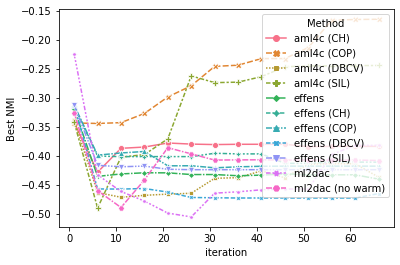

In [153]:
plot_data = results[(results["run"].isin([0]))
                    &(results["iteration"].isin(list(range(1, 71, 5))))
                     &(~results["dataset"].isin(bad_data))
                          #& (results["Method"].isin(["ml2dac", "effens"]))
                         #& (results["dataset"]=="zoo.csv")
                   ]
plot_data = plot_data.reset_index()
sns.lineplot(data=plot_data, 
             hue="Method",
             style="Method",
             markers=True,
             #markevery=5,
             x="iteration", 
             y="Best NMI", 
             ci=None)

In [102]:
results["max NMI"] = results.groupby(["Method", "dataset", "run"])["Best NMI"].transform(min)

In [103]:
max_nmi_results = results[results["Best NMI"] == results["max NMI"]]

In [154]:
results["max iteration"] = results.groupby(["Method", "dataset", "run"])["iteration"].transform(max)

In [155]:
max_iter_results = results[results["iteration"] == results["max iteration"]]
#max_iter_results[max_iter_results["max iteration"] == 70][["Method", "dataset", "iteration", "max iteration", "Best NMI"]].round(2)

In [146]:
results.columns


Index(['runtime', 'iteration', 'config', 'dataset', 'mf time',
       'similar dataset', 'cvi', 'algorithms', 'Method', 'CVI score',
       'wallclock time', 'Best CVI score', 'ARI', 'NMI', 'Best ARI',
       'Best NMI', 'best config', 'k_pred', 'config_ranking', 'run', 'cf',
       'gen_time', 'gen_ari', 'gen_nmi', 'gen_cvi', 'm', 'rs', 'max NMI',
       'max iteration'],
      dtype='object')

In [158]:
max_iter_results[(max_iter_results["run"] == 0)
                 &(max_iter_results["Method"] == "aml4c (DBCV)")].groupby(["dataset"])["Best NMI", "Best CVI score"].mean()

<ipython-input-158-7a60e472aae9>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  max_iter_results[(max_iter_results["run"] == 0) &(max_iter_results["Method"] == "aml4c (DBCV)")].groupby(["dataset"])["Best NMI", "Best CVI score", "best config"].min()


,Best NMI,Best CVI score,best config
dataset,,,
Fashion-MNIST_n10000_f784_c10.csv,-0.477399,1.000000,"{'algorithm': 'ward', 'linkage': 'complete', '..."
Fashion-MNIST_n20000_f784_c10.csv,-0.497162,1.000000,"{'algorithm': 'MBKMeans', 'n_clusters': 51}"
USPS_n9298_f256_c10.csv,-0.050424,-0.070570,"{'algorithm': 'dbscan', 'eps': 2.9498405300409..."
arrhythmia.csv,-0.091118,0.120015,"{'algorithm': 'spectral', 'assign_labels': 'cl..."
balance-scale.csv,-0.161216,-0.004089,"{'algorithm': 'spectral', 'assign_labels': 'cl..."
banknote_n1372_f4_k2.csv,-0.251762,-0.053107,"{'algorithm': 'spectral', 'assign_labels': 'cl..."
dermatology_n366_f33_k6.csv,-0.450943,-0.227673,"{'algorithm': 'ward', 'linkage': 'ward', 'n_cl..."
ecoli_n336_f8_k8.csv,-0.475628,-0.044750,"{'algorithm': 'GMM', 'n_clusters': 4}"
german.csv,-0.008538,0.008897,"{'algorithm': 'ward', 'linkage': 'ward', 'n_cl..."


In [175]:
results[(results["run"] == 0)
                 &(results["Method"] == "aml4c (DBCV)") 
                 & (results["dataset"].isin(["Fashion-MNIST_n20000_f784_c10.csv"]))][
    ["dataset","config", "best config","CVI score","Best CVI score"]]

,dataset,config,best config,CVI score,Best CVI score
0,Fashion-MNIST_n20000_f784_c10.csv,"{'algorithm': 'KMeans', 'n_clusters': 99}","{'algorithm': 'MBKMeans', 'n_clusters': 51}",2147483647.0,2.147484e+09
1,Fashion-MNIST_n20000_f784_c10.csv,"{'algorithm': 'KMeans', 'n_clusters': 73}","{'algorithm': 'MBKMeans', 'n_clusters': 51}",2147483647.0,2.147484e+09
2,Fashion-MNIST_n20000_f784_c10.csv,"{'algorithm': 'affinity_propagation', 'damping...","{'algorithm': 'MBKMeans', 'n_clusters': 51}",2147483647.0,2.147484e+09
3,Fashion-MNIST_n20000_f784_c10.csv,"{'algorithm': 'birch', 'n_clusters': 34}","{'algorithm': 'MBKMeans', 'n_clusters': 51}",2147483647.0,2.147484e+09
4,Fashion-MNIST_n20000_f784_c10.csv,"{'algorithm': 'birch', 'n_clusters': 67}","{'algorithm': 'MBKMeans', 'n_clusters': 51}",2147483647.0,2.147484e+09
...,...,...,...,...,...
0,Fashion-MNIST_n20000_f784_c10.csv,"{'algorithm': 'ward', 'linkage': 'average', 'n...","{'algorithm': 'MBKMeans', 'n_clusters': 51}",1.0,1.000000e+00
0,Fashion-MNIST_n20000_f784_c10.csv,"{'algorithm': 'ward', 'linkage': 'average', 'n...","{'algorithm': 'MBKMeans', 'n_clusters': 51}",1.0,1.000000e+00
0,Fashion-MNIST_n20000_f784_c10.csv,"{'algorithm': 'ward', 'linkage': 'average', 'n...","{'algorithm': 'MBKMeans', 'n_clusters': 51}",1.0,1.000000e+00
0,Fashion-MNIST_n20000_f784_c10.csv,"{'algorithm': 'ward', 'linkage': 'average', 'n...","{'algorithm': 'MBKMeans', 'n_clusters': 51}",1.0,1.000000e+00


In [119]:
max_iter_results[(max_iter_results["run"] == 0) 
                 &(max_iter_results["Method"] == "ml2dac")
                ].groupby(["dataset"])["Best NMI"].mean()

dataset
Fashion-MNIST_n10000_f784_c10.csv   -0.183068
Fashion-MNIST_n20000_f784_c10.csv   -0.189516
Fashion-MNIST_n30000_f784_c10.csv   -0.148680
Fashion-MNIST_n40000_f784_c10.csv   -0.539621
Fashion-MNIST_n50000_f784_c10.csv   -0.486644
Fashion-MNIST_n60000_f784_c10.csv   -0.499249
USPS_n9298_f256_c10.csv             -0.000003
arrhythmia.csv                      -0.145736
balance-scale.csv                   -0.169319
banknote_n1372_f4_k2.csv            -0.254389
dermatology_n366_f33_k6.csv         -0.434867
ecoli_n336_f8_k8.csv                -0.102604
german.csv                           0.000283
glass.csv                           -0.353110
haberman.csv                        -0.008269
heart-statlog.csv                   -0.133038
iono.csv                            -0.256376
iris_n150_f5_k3.csv                 -0.731585
letter_n20000_f16_c26.csv           -0.524827
pendigits_n10992_f16_c10.csv        -0.704564
segment.csv                         -0.001210
sonar.csv                 

In [142]:
all_mnist_data = [f"Fashion-MNIST_n{i}0000_f784_c10.csv" for i in range(1,8)]
max_iter_results[(max_iter_results["Method"] == "ml2dac")
                 & (max_iter_results["dataset"].isin(all_mnist_data))
                ][["run", "dataset", "Method", "cvi", "Best NMI", "best config"]]

,run,dataset,Method,cvi,Best NMI,best config
99,0,Fashion-MNIST_n10000_f784_c10.csv,ml2dac,CH,-1.830683e-01,"{'algorithm': 'KMeans', 'n_clusters': 2}"
77,0,Fashion-MNIST_n20000_f784_c10.csv,ml2dac,CH,-1.895160e-01,"{'algorithm': 'KMeans', 'n_clusters': 2}"
0,0,Fashion-MNIST_n30000_f784_c10.csv,ml2dac,CH,-1.486798e-01,"{'algorithm': 'MBKMeans', 'n_clusters': 2}"
0,0,Fashion-MNIST_n40000_f784_c10.csv,ml2dac,CH,-5.396214e-01,"{'algorithm': 'MBKMeans', 'n_clusters': 9}"
0,0,Fashion-MNIST_n50000_f784_c10.csv,ml2dac,CH,-4.866439e-01,"{'algorithm': 'MBKMeans', 'n_clusters': 10}"
0,0,Fashion-MNIST_n60000_f784_c10.csv,ml2dac,CH,-4.992490e-01,"{'algorithm': 'MBKMeans', 'n_clusters': 10}"
99,1,Fashion-MNIST_n10000_f784_c10.csv,ml2dac,SIL,1.994467e-15,"{'algorithm': 'ward', 'linkage': 'single', 'n_..."
0,1,Fashion-MNIST_n20000_f784_c10.csv,ml2dac,SIL,2.759880e-15,"{'algorithm': 'ward', 'linkage': 'average', 'n..."
0,1,Fashion-MNIST_n50000_f784_c10.csv,ml2dac,SIL,-5.187642e-01,"{'algorithm': 'MBKMeans', 'n_clusters': 10}"
0,1,Fashion-MNIST_n60000_f784_c10.csv,ml2dac,SIL,-5.067541e-01,"{'algorithm': 'MBKMeans', 'n_clusters': 10}"


In [134]:
all_mnist_data = [f"Fashion-MNIST_n{i}0000_f784_c10.csv" for i in range(1,8)]
max_iter_results[(max_iter_results["Method"] == "effens")
                 & (max_iter_results["dataset"].isin(all_mnist_data))
                ][["run", "dataset", "Method", "cvi", "Best NMI", "best config"]]

,run,dataset,Method,cvi,Best NMI,best config
69,0,Fashion-MNIST_n10000_f784_c10.csv,effens,CH,-0.271353,"{'cc_function': 'ACV', 'k': 2, 'm': 7}"
69,0,Fashion-MNIST_n20000_f784_c10.csv,effens,CH,-0.249055,"{'cc_function': 'ACV', 'k': 2, 'm': 7}"
69,0,Fashion-MNIST_n30000_f784_c10.csv,effens,CH,-0.357968,"{'cc_function': 'ACV', 'k': 2, 'm': 7}"
69,0,Fashion-MNIST_n40000_f784_c10.csv,effens,CH,-0.368760,"{'cc_function': 'ACV', 'k': 2, 'm': 7}"
69,0,Fashion-MNIST_n50000_f784_c10.csv,effens,CH,-0.369841,"{'cc_function': 'ACV', 'k': 2, 'm': 7}"
69,0,Fashion-MNIST_n60000_f784_c10.csv,effens,CH,-0.291986,"{'cc_function': 'ACV', 'k': 2, 'm': 7}"
69,1,Fashion-MNIST_n10000_f784_c10.csv,effens,SIL,-0.229401,"{'cc_function': 'ACV', 'k': 2, 'm': 7}"
69,1,Fashion-MNIST_n20000_f784_c10.csv,effens,SIL,-0.210974,"{'cc_function': 'ACV', 'k': 2, 'm': 7}"
69,1,Fashion-MNIST_n50000_f784_c10.csv,effens,SIL,-0.233106,"{'cc_function': 'ACV', 'k': 2, 'm': 7}"
69,1,Fashion-MNIST_n60000_f784_c10.csv,effens,SIL,-0.368707,"{'cc_function': 'ACV', 'k': 2, 'm': 7}"


In [141]:
results[(~results["dataset"].isin(bad_data)) &
        (results["iteration"] == 25) 
        & (~results["dataset"].isin(fmnist_data_not_ready))
].groupby(["run","Method"])[["Best ARI", "Best NMI", "wallclock time"]].mean()

Best ARI  Best NMI  wallclock time
run Method                                              
0   aml4c (CH)       -0.288229 -0.380210      202.786846
    aml4c (COP)      -0.095941 -0.277579      281.953647
    aml4c (DBCV)     -0.234848 -0.441950      310.118581
    aml4c (SIL)      -0.230266 -0.298889      312.987230
    effens           -0.312512 -0.448577       41.790773
    effens (CH)      -0.310229 -0.401801       25.823630
    effens (COP)     -0.214063 -0.417574       36.578573
    effens (DBCV)    -0.292189 -0.472301       56.352191
    effens (SIL)     -0.325692 -0.424363       39.203471
    ml2dac           -0.369901 -0.500856      191.791320
    ml2dac (no warm) -0.296381 -0.397003       78.005858
1   aml4c (CH)       -0.353329 -0.446219       60.099670
    aml4c (COP)      -0.009002 -0.011582        0.764827
    aml4c (DBCV)     -0.238115 -0.252697        1.199186
    aml4c (SIL)      -0.265718 -0.360931       57.760722
    effens           -0.305723 -0.431842       47.031807
    effens (CH)      -0.322720 -0.411354       27.079420
    effens (COP)     -0.125490 -0.337889      133.923467
    effens (DBCV)    -0.186971 -0.333546      191.005219
    effens (SIL)     -0.343679 -0.447573       36.373076
    ml2dac           -0.306326 -0.445315      196.729222
    ml2dac (no warm) -0.281009 -0.426181       83.941156

In [123]:
bad_data = ["haberman.csv", "german.csv", "balance-scale.csv", "arrhythmia.csv", 
            "heart-statlog.csv", 
            "sonar.csv", 
            "tae.csv", 
            "vehicle.csv"]

max_iter_results.groupby(["run", "Method"])[["Best NMI",
                                               "Best ARI", "wallclock time"]].median().round(2)

Best NMI  Best ARI  wallclock time
run Method                                              
0   aml4c (CH)           -0.22     -0.12            3.71
    aml4c (COP)          -0.10     -0.01            6.34
    aml4c (DBCV)         -0.25     -0.06           18.06
    aml4c (SIL)          -0.02     -0.00            3.85
    effens               -0.36     -0.14           26.27
    effens (CH)          -0.24     -0.12           13.06
    effens (COP)         -0.27     -0.09           15.44
    effens (DBCV)        -0.32     -0.14           17.21
    effens (SIL)         -0.23     -0.11           15.39
    ml2dac               -0.19     -0.09           11.96
    ml2dac (no warm)     -0.18     -0.05            5.15
1   aml4c (CH)           -0.24     -0.12            3.18
    aml4c (COP)          -0.01     -0.01            1.77
    aml4c (DBCV)         -0.13     -0.02            6.42
    aml4c (SIL)          -0.03     -0.01            3.96
    effens               -0.24     -0.10           19.96
    effens (CH)          -0.26     -0.14           13.46
    effens (COP)         -0.37     -0.17          379.44
    effens (DBCV)        -0.33     -0.19          512.93
    effens (SIL)         -0.25     -0.11           14.50
    ml2dac               -0.22     -0.05            5.69
    ml2dac (no warm)     -0.16     -0.03            6.84

In [22]:
max_iter_results[(~max_iter_results["dataset"].isin(bad_data)) 
                 & (max_iter_results["run"] ==2)
       ].groupby(["Method"])["Best NMI", "Best ARI", "wallclock time"].mean()

<ipython-input-22-578ada36c6a7>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  max_iter_results[(~max_iter_results["dataset"].isin(bad_data))


""
Method
aml4c (CH)
aml4c (SIL)
effens
effens (CH)
effens (SIL)
ml2dac
ml2dac (no warm)


In [28]:
results[results["Method"] == "effens"]["gen_nmi"].mean()

-0.2857683923224489

In [64]:
results[results["dataset"] == "Fashion-MNIST_n60000_f784_c10.csv"]["cvi"].unique()

array(['CH'], dtype=object)

In [78]:
max_iter_results[max_iter_results["dataset"] == "Fashion-MNIST_n60000_f784_c10.csv"].groupby(["dataset", "Method"])["Best NMI", "Best ARI", "wallclock time", "cvi"].mean()

<ipython-input-78-44ee758479f5>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  max_iter_results[max_iter_results["dataset"] == "Fashion-MNIST_n60000_f784_c10.csv"].groupby(["dataset", "Method"])["Best NMI", "Best ARI", "wallclock time", "cvi"].mean()


Best NMI  Best ARI  wallclock time
dataset                           Method                                    
Fashion-MNIST_n60000_f784_c10.csv effens -0.291986 -0.129539     1332.444633
                                  ml2dac -0.499249 -0.345895     8422.891037

In [67]:
results[results["dataset"] == "Fashion-MNIST_n60000_f784_c10.csv"].groupby(["dataset", "Method"])["Best NMI", "Best ARI", "wallclock time", "cvi"].min()

<ipython-input-67-cb9e0c048553>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  results[results["dataset"] == "Fashion-MNIST_n60000_f784_c10.csv"].groupby(["dataset", "Method"])["Best NMI", "Best ARI", "wallclock time", "cvi"].min()


Best NMI  Best ARI  wallclock time  \
dataset                           Method                                       
Fashion-MNIST_n60000_f784_c10.csv effens -0.368707 -0.163044       25.791902   
                                  ml2dac -0.547435 -0.375092      711.088890   

                                         cvi  
dataset                           Method      
Fashion-MNIST_n60000_f784_c10.csv effens  CH  
                                  ml2dac  CH